<a href="https://colab.research.google.com/github/romanfen/F21DL-G6/blob/main/Lab8_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [1]:
import sys
sys.path
from platform import python_version
assert sys.version_info >= (3, 5)
print(python_version())

import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
from pylab import rcParams
import seaborn as sb

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

3.7.15


## Load Data from GitHub

In [2]:
# Load the data
def load_data():
    url = "https://raw.githubusercontent.com/romanfen/F21DL-G6/main/datasets/Maths.csv"
    return pd.read_csv(url)

students = load_data()
students_cols = list(students.columns)
print(students_cols)

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


# Data Prep

## Binning

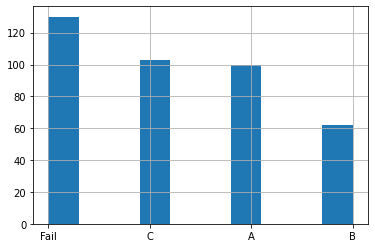

In [3]:
# Sort Grade 3 results into A,B,C and Fail Grades
# A >= 70%
# B >= 60%
# C >= 50%
# Fail < 70%

def bin_grades(dataset):
  dataset['G3_cat'] = pd.cut(dataset['G3'],
                            bins=[-np.inf, 9.0, 11.0, 13.0, 20],
                            labels=['Fail', 'C', 'B', 'A'])
  
bin_grades(students)
students['G3_cat'].hist()

## Data Subsets

In order to find relationships between the features of our data we will split the data into smaller datasets.

activities_data - This dataset will contain infortmation relating to a students extra-cirricular activities

family_data - This dataset will contain information relating to a students family life.

school_data - This dataset will contain information relating to a students school and study habits.

personal_data - This dataset contains information relating to the invdividuals lifestyle and health

In [9]:
activities_data = students[['activities','romantic','freetime','goout','Dalc','Walc','G1','G2','G3','G3_cat']]
family_data = students[['famsize','Pstatus','Medu','Fedu','Mjob','Fjob','guardian','famsup','internet','G3','G3_cat']]
school_data = students[['school','studytime','failures','schoolsup','paid','nursery','higher','absences','G3_cat']]#,'G1','G2',,'G3_cat']]
personal_data = students[['school','sex','age','Dalc','Walc','health','absences','G1','G2','G3','G3_cat']]

subsets = [activities_data, family_data, school_data, personal_data]

The decisions trees will look at the personal data, so we will create training sets and test sets

In [15]:
# Can also do stratified data split
from sklearn.model_selection import StratifiedShuffleSplit

def split_dataset(data, ratio):
  split = StratifiedShuffleSplit(n_splits=1, test_size=ratio, random_state=42)
  for train_index, test_index in split.split(data, data["G3_cat"]):
      strat_train_set = data.loc[train_index]
      strat_test_set = data.loc[test_index]
  return strat_train_set, strat_test_set

In [16]:
# Split training 80% test 20%
personal_train_8020, personal_test_8020 = split_dataset(personal_data, 0.2)
personal_target_8020 = personal_train_8020['G3_cat'].copy()
personal_train_8020, personal_test_8020 = personal_train_8020.drop(['G3_cat'], axis=1), personal_test_8020.drop(['G3_cat'], axis=1)

# Split training 50% test 50%
personal_train_5050, personal_test_5050 = split_dataset(personal_data, 0.5)
personal_target_5050 = personal_train_5050['G3_cat'].copy()
personal_train_5050, personal_test_5050 = personal_train_5050.drop(['G3_cat'], axis=1), personal_test_5050.drop(['G3_cat'], axis=1)

# Split training 20% test 80%
personal_train_2080, personal_test_2080 = split_dataset(personal_data, 0.8)
personal_target_2080 = personal_train_2080['G3_cat'].copy()
personal_train_2080, personal_test_8020 = personal_train_2080.drop(['G3_cat'], axis=1), personal_test_2080.drop(['G3_cat'], axis=1)

## Pipeline

In [17]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

def get_types(dataset):
  num_attr = list(dataset.select_dtypes(include='number'))
  cat_attr = list(dataset.select_dtypes(exclude='number'))
  print(num_attr, cat_attr)
  return num_attr, cat_attr

num, cat = get_types(personal_train_8020)

num_pipeline = Pipeline([
      ('MnMx_scaler', MinMaxScaler()),
  ])
cat_pipeline = OrdinalEncoder()

full_pipeline =  ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num),#  Apply the numerical transformation to the all numeric columns
        ("cat", cat_pipeline, cat), # Apply the One Hot Encoding to the all categorical columns
  ])

['age', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3'] ['school', 'sex']


In [18]:
prep_8020 = full_pipeline.fit_transform(personal_train_8020)
prep_5050 = full_pipeline.fit_transform(personal_train_5050)
prep_2080 = full_pipeline.fit_transform(personal_train_2080)

print(personal_train_8020.head())
print(prep_8020[3])

    school sex  age  Dalc  Walc  health  absences  G1  G2  G3
107     GP   M   16     1     1       5         2  16  18  18
355     MS   F   18     1     1       5         0  10   9   9
121     GP   M   15     1     2       5         6  16  14  15
36      GP   M   15     1     1       4         2  15  16  18
112     GP   F   16     1     1       5         6  10  13  13
[0.         0.         0.         0.75       0.02666667 0.75
 0.84210526 0.9        0.         1.        ]


# Decision Trees

In [21]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

# create the decision trees
tree_8020_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_8020_2.fit(prep_8020, personal_target_8020)

# create the decision trees
tree_HalfSplit_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_HalfSplit_2.fit(prep_5050, personal_target_5050)

# create the decision trees
tree_2080_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_2080_2.fit(prep_2080, personal_target_2080)

DecisionTreeClassifier(max_depth=2, random_state=42)

[Text(0.4, 0.8333333333333334, 'X[7] <= 0.475\ngini = 0.735\nsamples = 316\nvalue = [80, 50, 82, 104]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 104\nvalue = [0, 0, 0, 104]'),
 Text(0.6, 0.5, 'X[7] <= 0.575\ngini = 0.652\nsamples = 212\nvalue = [80, 50, 82, 0]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 82\nvalue = [0, 0, 82, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.473\nsamples = 130\nvalue = [80, 50, 0, 0]')]

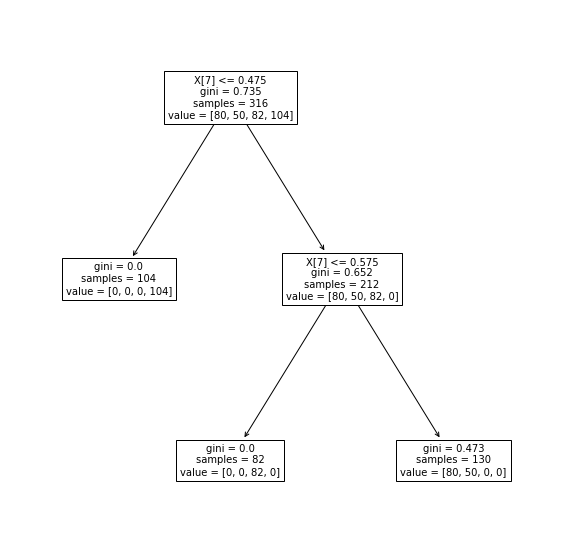

In [22]:
plt.figure(figsize=(10,10))
plot_tree(tree_8020_2, fontsize=10)

[Text(0.4, 0.8333333333333334, 'X[7] <= 0.475\ngini = 0.735\nsamples = 197\nvalue = [50, 31, 51, 65]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 65\nvalue = [0, 0, 0, 65]'),
 Text(0.6, 0.5, 'X[7] <= 0.575\ngini = 0.652\nsamples = 132\nvalue = [50, 31, 51, 0]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 51\nvalue = [0, 0, 51, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.472\nsamples = 81\nvalue = [50, 31, 0, 0]')]

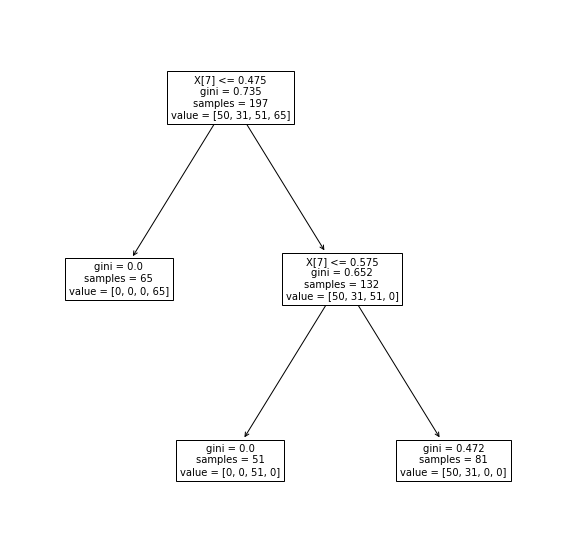

In [24]:
plt.figure(figsize=(10,10))
plot_tree(tree_HalfSplit_2, fontsize=10)

[Text(0.4, 0.8333333333333334, 'X[7] <= 0.475\ngini = 0.734\nsamples = 79\nvalue = [20, 12, 21, 26]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 26\nvalue = [0, 0, 0, 26]'),
 Text(0.6, 0.5, 'X[7] <= 0.575\ngini = 0.649\nsamples = 53\nvalue = [20, 12, 21, 0]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 21\nvalue = [0, 0, 21, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.469\nsamples = 32\nvalue = [20, 12, 0, 0]')]

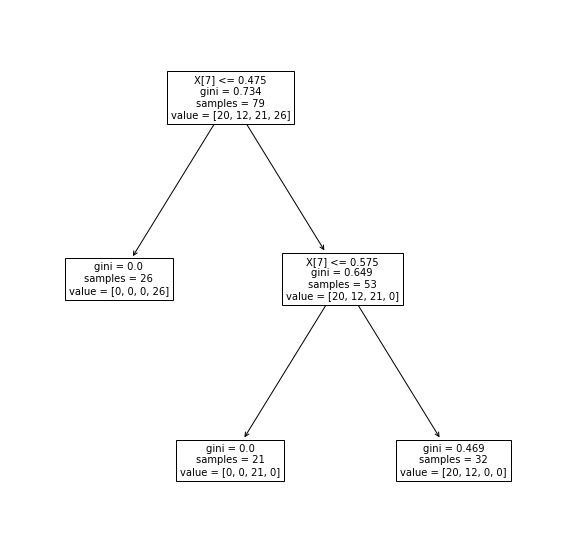

In [23]:
plt.figure(figsize=(10,10))
plot_tree(tree_2080_2, fontsize=10)

# Accuracy Tests

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [27]:
def testModel(model, test_data, predict):
  train_pred = cross_val_predict(model, test_data, predict, cv=10)
  cM = confusion_matrix(predict, train_pred)
  TPos, FPos, TNeg, FNeg = cM[0][0] , cM[0][1] , cM[1][0] , cM[1][1]
  print("Accuracy :" , np.mean(cross_val_score(model, test_data, predict, cv=10, scoring="accuracy")))
  print("Confusion Matrix: " , cM)
  print("True Positives: " , TPos)
  print("False Positives: " , FPos)
  print("False Negatives: " , FNeg)
  print("True Negatives: " , TNeg)
  print("Sensitivity: " , cM[0][0] / (cM[0][0]+cM[1][0]))
  print("Specificity: " , cM[1][1] / (cM[1][1]+cM[0][1]))
  print("Precision: ", precision_score(predict, train_pred, average='micro'))
  print("Recall: " , recall_score(predict, train_pred, average='micro'))
  print("F1 Score: " , f1_score(predict, train_pred, average='micro'))

In [28]:
testModel(tree_8020_2, prep_8020, personal_target_8020)

Accuracy : 0.841733870967742
Confusion Matrix:  [[ 80   0   0   0]
 [ 50   0   0   0]
 [  0   0  82   0]
 [  0   0   0 104]]
True Positives:  80
False Positives:  0
False Negatives:  0
True Negatives:  50
Sensitivity:  0.6153846153846154
Specificity:  nan
Precision:  0.8417721518987342
Recall:  0.8417721518987342
F1 Score:  0.8417721518987342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [30]:
testModel(tree_HalfSplit_2, prep_5050, personal_target_5050)

Accuracy : 0.8426315789473684
Confusion Matrix:  [[50  0  0  0]
 [31  0  0  0]
 [ 0  0 51  0]
 [ 0  0  0 65]]
True Positives:  50
False Positives:  0
False Negatives:  0
True Negatives:  31
Sensitivity:  0.6172839506172839
Specificity:  nan
Precision:  0.8426395939086294
Recall:  0.8426395939086294
F1 Score:  0.8426395939086294


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [31]:
testModel(tree_2080_2, prep_2080, personal_target_2080)

Accuracy : 0.8482142857142858
Confusion Matrix:  [[20  0  0  0]
 [12  0  0  0]
 [ 0  0 21  0]
 [ 0  0  0 26]]
True Positives:  20
False Positives:  0
False Negatives:  0
True Negatives:  12
Sensitivity:  0.625
Specificity:  nan
Precision:  0.8481012658227848
Recall:  0.8481012658227848
F1 Score:  0.8481012658227848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
